# Basic workflow with ART for evasion attacks and defences

In this notebook we will show
- how to work with a Keras image classifier in ART
- how ART actually abstracts from the specific ML/DL backend
- how to apply a Projected Gradient Descent (PGD) evasion attack against that classifier
- how to deploy defences against such attacks
- how to create adversarial samples that can bypass those defences

## Load prerequisites

You can preinstall all prerequisites by uncommenting and running the following cell.

In [ ]:
pip install --upgrade --user adversarial-robustness-toolbox
pip install --upgrade --user numpy==1.16.4
pip install --upgrade --user keras==2.2.4
pip install --upgrade --user matplotlib==3.1.0

In [1]:
# Load basic dependencies:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np

# Install ImageNet stubs
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

# Load Keras dependencies:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input


from keras.preprocessing import image

# Load ART dependencies:
from art.classifiers import KerasClassifier
from art.attacks import *
from art.defences import *
from art.metrics import clever
from art.metrics import clever_t

from art.utils import to_categorical

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-i9p_cxcj
  Running setup.py bdist_wheel for imagenet-stubs ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbey96nx/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


Using TensorFlow backend.


## Load images

We are going to load a set of 16 example images for illustration purposes.

In [2]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)

images = np.array(images_list)

The images all have a resolution of 224 x 224 pixels, and 3 color channels (RGB).

In [3]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


As default choice, we are going to use the last image (`idx = 15`) for illustration purposes. <br>
But you could use any other of the 16 images in the following (just change the value of the `idx` variable).

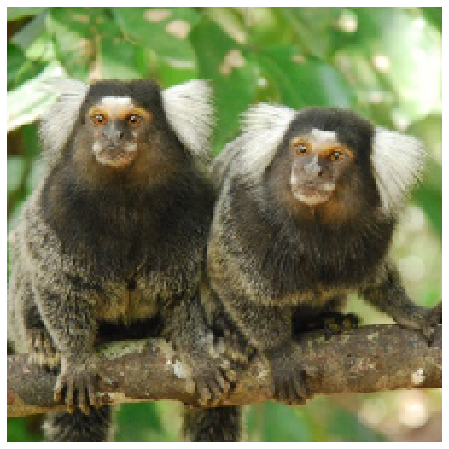

In [4]:
idx = 15

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

## Load ResNet50 classifier

Next we are going to use a state-of-the-art classifier on those images.

In [5]:
# This loads the pretrained ResNet50 model:
model = ResNet50(weights='imagenet')
model2 = VGG19(weights='imagenet')

Let's look at the prediction that this model yields for the selected image:

In [6]:
# We need to expand the input dimension and apply the preprocessing required for ResNet50:
x = np.expand_dims(images[idx].copy(), axis=0)
x = preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction M1:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))


# Then apply the model, determine the predicted label and confidence:
pred = model2.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction M2:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction M1: marmoset - confidence 0.85
Prediction M2: marmoset - confidence 0.89


So the model correctly tells us that this image shows a notebook computer, which is good :-)

Next we will create an ART KerasClassifier wrapper around the model. <br>
We need to take care of the `preprocess_input` logic that has to be applied:

- swap the order of the color channels (RGB -> BGR)
- subtract the channel means

In [7]:
# Provide the channel means as input for the ART KerasClassifier:
mean_imagenet = np.array([103.939, 116.779, 123.68])

# Create the classifier wrapper:
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, 1))
classifier2 = KerasClassifier(clip_values=(0, 255), model=model2, preprocessing=(mean_imagenet, 1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now we will apply the classifier object to obtain the prediction.

**Note:** we have to swap the color channel order (from RGB to BGR) before feeding the input to the classifier

In [8]:
# Same as for the original model, we expand the dimension of the inputs.
# We also swap the color channels (RGB -> BGR):
x_art = np.expand_dims(images[idx], axis=0)[..., ::-1] 

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction model 1:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))


# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier2.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction model 2:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction model 1: marmoset - confidence 0.85
Prediction model 2: marmoset - confidence 0.89


So through the classifier API we obtain the same predictions as from the raw model, but now we have an abstraction from the actual backend (e.g. Keras).

The classifier wrapper allows us to call other functions besides predict.

For example, we can obtain the **loss gradient** of the classifier, which is used in many of the algorithms for adversarial sample generation:

## Create adversarial samples

Next, we are going to create an adversarial sample. <br>
We are going to use **Projected Gradient Descent (PGD)**, which is one of the strongest existing attacks. <br>
We will first perform an **untargeted** adversarial attack.

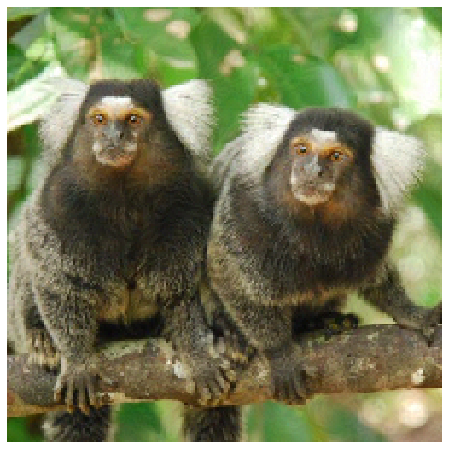

Prediction Model1: titi, titi monkey - confidence 1.00


In [9]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction Model1:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

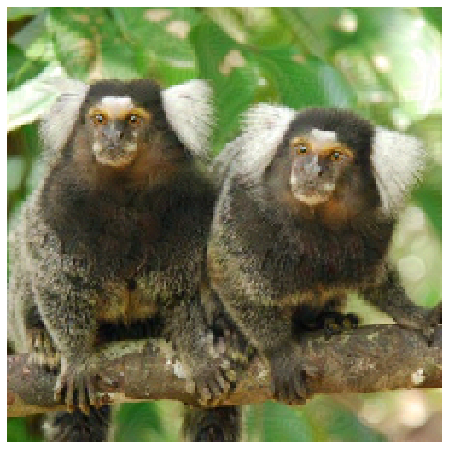

Prediction Model 2: titi, titi monkey - confidence 1.00


In [10]:
# Create the attacker:
adv2 = ProjectedGradientDescent(classifier2, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv2.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier2.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction Model 2:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Next, we will perform a **targeted attack** where we pick the class that we want the classifier to predict on the adversarial sample. <br>
Below is the list of labels and class names - make your pick!

In [11]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

label 638 - maillot
label 639 - maillot, tank suit
label 640 - manhole cover
label 641 - maraca
label 642 - marimba, xylophone
label 643 - mask
label 644 - matchstick
label 645 - maypole
label 646 - maze, labyrinth
label 647 - measuring cup
label 648 - medicine chest, medicine cabinet
label 649 - megalith, megalithic structure
label 650 - microphone, mike
label 651 - microwave, microwave oven
label 652 - military uniform
label 653 - milk can
label 654 - minibus
label 655 - miniskirt, mini
label 656 - minivan
label 657 - missile
label 658 - mitten
label 659 - mixing bowl
label 660 - mobile home, manufactured home
label 661 - Model T
label 662 - modem
label 663 - monastery
label 664 - monitor
label 665 - moped
label 666 - mortar
label 667 - mortarboard
label 668 - mosque
label 669 - mosquito net
label 670 - motor scooter, scooter
label 671 - mountain bike, all-terrain bike, off-roader
label 672 - mountain tent
label 673 - mouse, computer mouse
label 674 - mousetrap
label 675 - moving van

As default, let's get this image misclassified as minibus (label 654)!

In [12]:
target_label = 654

Now let's perform the targeted attack on VGG50 model:

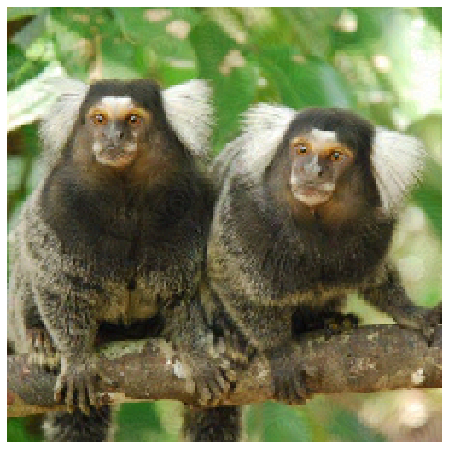

Prediction: minibus - confidence 1.00


In [26]:
# Set the configuration to a targeted attack:
#adv = FastGradientMethod(classifier, eps=30)
#adv = DeepFool(classifier, max_iter=50, batch_size=128)
adv = ProjectedGradientDescent(classifier, targeted=True, max_iter=10, eps_step=1, eps=5)
#adv = SaliencyMapMethod(classifier, theta=1, batch_size=1)

# Generate the adversarial sample:


x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))



#adv = CarliniLInfMethod(classifier, targeted=True, max_iter=10, eps=0.5)




# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

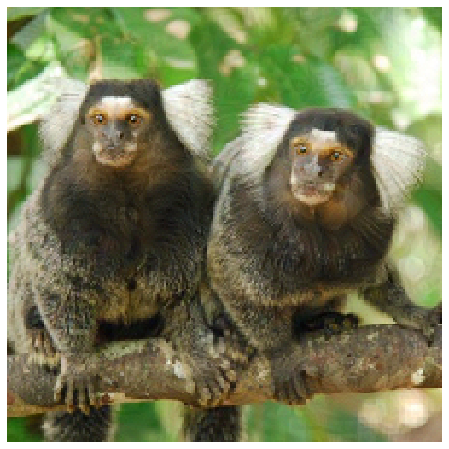

Prediction model 2 : minibus - confidence 0.38


In [33]:
# Set the configuration to a targeted attack:
#adv2 = FastGradientMethod(classifier2, eps=30.0)
#adv2 = DeepFool(classifier2, max_iter=50, batch_size=128)
adv2 = ProjectedGradientDescent(classifier2, targeted=True, max_iter=10, eps_step=1, eps=5)


# Generate the adversarial sample:
x_art_adv2 = adv2.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv2[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv2 = classifier2.predict(x_art_adv2)
label_adv2 = np.argmax(pred_adv2, axis=1)[0]
confidence_adv2 = pred_adv2[:, label_adv2][0]
print('Prediction model 2 :', label_to_name(label_adv2), '- confidence {0:.2f}'.format(confidence_adv2))

## Apply defences

Next we are going to apply a simple input preprocessing defence: Jpeg compression and Spatial Smoothing. <br>
Ideally, we want this defence to result in correct predictions when applied both to the original and the adversarial images.


===== DEFENSE 1 ======

Jpeg compression defense VS ResNet model

Prediction of original sample: marmoset - confidence 0.56
Prediction of adversarial sample: marmoset - confidence 0.51


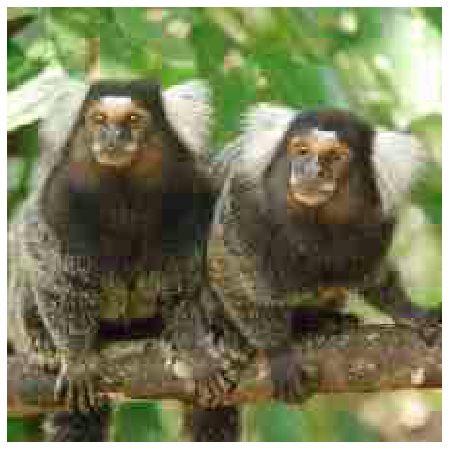

In [31]:
# Initalize the JpegCompression defense. 
clip_values = (0, 255)
jp = JpegCompression(clip_values=clip_values, quality=19)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = jp(x_art)
x_art_adv_def, _ = jp(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

<b>===== DEFENSE 1 ======</b>

Jpeg compression defense VS VGG19 model

Prediction of original sample: marmoset - confidence 0.65
Prediction of adversarial sample: marmoset - confidence 0.52


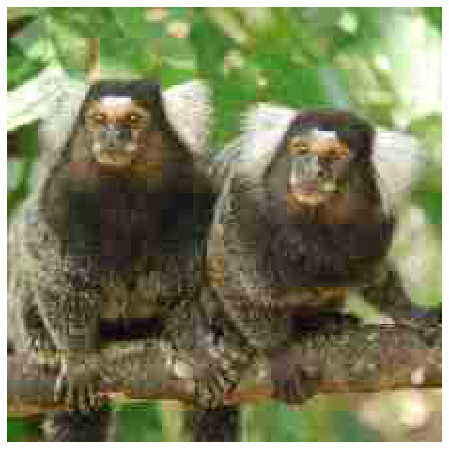

In [35]:
# Initalize the JpegCompression defence. 
clip_values = (0, 255)
jp = JpegCompression(clip_values=clip_values, quality=18)


# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def2, _ = jp(x_art)
x_art_adv_def2, _ = jp(x_art_adv2)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def2)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def2 = classifier.predict(x_art_adv_def2)
label_adv_def2 = np.argmax(pred_adv_def2, axis=1)[0]
confidence_adv_def2 = pred_adv_def2[:, label_adv_def2][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def2), 
      '- confidence {0:.2f}'.format(confidence_adv_def2))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def2[0][..., ::-1] / 255); plt.axis('off'); plt.show()

<b>===== DEFENSE 2 ======</b>




SpatialSmoothing defense VS ResNet50 model

Prediction of original sample: marmoset - confidence 0.99
Prediction of adversarial sample: marmoset - confidence 0.98


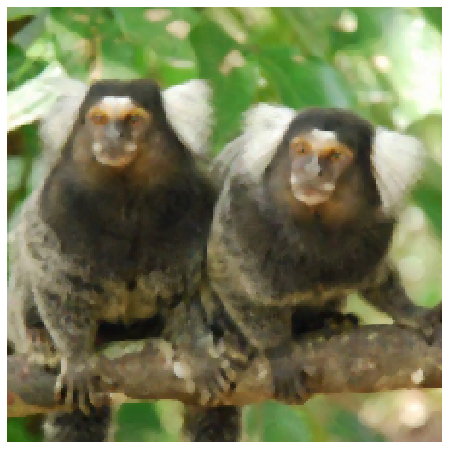

In [36]:
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

In [ ]:
SpatialSmoothing defense VS VGG19 model

Prediction of original sample: marmoset - confidence 0.99
Prediction of adversarial sample: marmoset - confidence 0.98


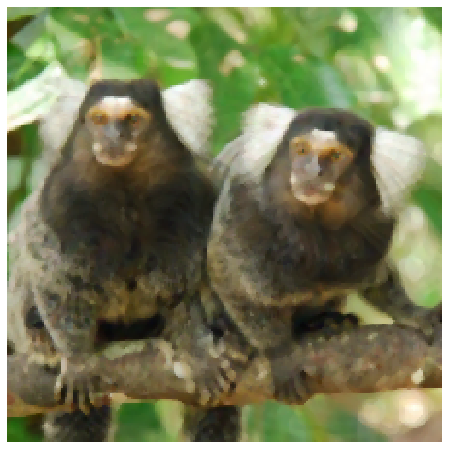

In [37]:
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def2, _ = ss(x_art)
x_art_adv_def2, _ = ss(x_art_adv2)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def2)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def2 = classifier.predict(x_art_adv_def2)
label_adv_def2 = np.argmax(pred_adv_def2, axis=1)[0]
confidence_adv_def2 = pred_adv_def2[:, label_adv_def2][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def2), 
      '- confidence {0:.2f}'.format(confidence_adv_def2))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def2[0][..., ::-1] / 255); plt.axis('off'); plt.show()

Trying another defense

In [47]:
#x_art_adv_mod = x_art_adv.convert('RGB')

clv = clever_t(classifier, x_art_adv[0][..., ::-1] / 255, target_label, 10, 5, 0.1 , np.inf, c_init=1, pool_factor=10)

KeyboardInterrupt: 

## Conclusions

We have walked through an end-to-end example of using a Keras image classifier in ART, creating adversarial samples and deploying input preprocessing defences.